# Practice - Model Specification

## Setup

In [1]:
library(readr)

## Importing Data

For this practice we will be using the U.S. Current Population Survey (2015) dataset.

In [2]:
urlfile <- "https://raw.githubusercontent.com/mvillalbao/CausalInferenceML/refs/heads/main/data/wage2015_subsample_inference.csv"

data <- read_csv(url(urlfile))
head(data)

Rows: 5150 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (21): rownames, wage, lwage, sex, shs, hsg, scl, clg, ad, mw, so, we, ne...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


rownames,wage,lwage,sex,shs,hsg,scl,clg,ad,mw,⋯,we,ne,exp1,exp2,exp3,exp4,occ,occ2,ind,ind2
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
10,9.615385,2.263364,1,0,0,0,1,0,0,⋯,0,1,7,0.49,0.343,0.2401,3600,11,8370,18
12,48.076923,3.872802,0,0,0,0,1,0,0,⋯,0,1,31,9.61,29.791,92.3521,3050,10,5070,9
15,11.057692,2.403126,0,0,1,0,0,0,0,⋯,0,1,18,3.24,5.832,10.4976,6260,19,770,4
18,13.942308,2.634928,1,0,0,0,0,1,0,⋯,0,1,25,6.25,15.625,39.0625,420,1,6990,12
19,28.846154,3.361977,1,0,0,0,1,0,0,⋯,0,1,22,4.84,10.648,23.4256,2015,6,9470,22
30,11.730769,2.462215,1,0,0,0,1,0,0,⋯,0,1,1,0.01,0.001,0.0001,1650,5,7460,14


**Variable dictionary**

- occ : occupational classification
- ind : industry classification
- lwage : log hourly wage
- sex : gender (1 female) (0 male)
- shs : some high school
- hsg : High school graduated
- scl : Some College
- clg: College Graduate
- ad: Advanced Degree
- ne: Northeast
- mw: Midwest
- so: South
- we: West
- exp1: experience

## Data Cleaning

In [3]:
# Create the variable 'high_wage'
data$high_wage <- ifelse(data$wage > mean(data$wage), 1, 0)

# Create the variable 'college_or_above'
data$college_or_above <- ifelse(data$clg == 1 | data$ad == 1, 1, 0)

# Create the education variable based on the highest level of education attained
data$education <- factor(ifelse(data$ad == 1, "AD",       # Advanced Degree
                                ifelse(data$clg == 1, "CLG",  # College Degree
                                ifelse(data$scl == 1, "SCL",  # Some College
                                ifelse(data$hsg == 1, "HSG",  # High School Grad
                                ifelse(data$shs == 1, "SHS",  # Some High School
                                "NONE"))))),                 # No education
                         levels = c("NONE", "SHS", "HSG", "SCL", "CLG", "AD"))


## Data Analysis

### Case 1: Continuous Y and continuous X with intercept

In this first case, we may want to explore how **experience** (`exp2`) relates to **wage** (our dependent variable). Since both **experience** and **wage** are continuous variables, we can apply a simple linear regression model with an intercept to capture this relationship.

**Regression Model**:

$$
\text{wage} = \beta_0 + \beta_1 \cdot \text{experience} + \epsilon
$$

- $ \beta_0 $: The **intercept**, representing the expected wage when experience is 0. This provides a baseline estimate.
- $ \beta_1 $: The **slope coefficient** on experience, which tells us how much we expect **wage** to change for a **one-unit increase** in experience (i.e., for each additional year of experience).

**Interpretation**:
In this context, the coefficient $ \beta_1 $ on **experience** is interpreted as the **marginal effect** of an additional year of experience on wage. For instance, if $ \beta_1 = 2 $, it would mean that for every additional year of experience, wage is predicted to increase by 2 units.

Let's now estimate this relationship and review the regression output to interpret the results.

In [4]:
model1 <- lm(wage ~ exp2, data = data)
summary(model1)



Call:
lm(formula = wage ~ exp2, data = data)

Residuals:
   Min     1Q Median     3Q    Max 
-22.62 -10.07  -4.24   4.23 505.55 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 22.64819    0.36626  61.836  < 2e-16 ***
exp2         0.25248    0.07308   3.455 0.000555 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 20.98 on 5148 degrees of freedom
Multiple R-squared:  0.002313,	Adjusted R-squared:  0.002119 
F-statistic: 11.94 on 1 and 5148 DF,  p-value: 0.0005551


In [5]:
# Extract the coefficients from the model
coef_model1 <- summary(model1)$coefficients

# Extract the specific coefficient
beta_1 <- coef_model1["exp2", "Estimate"]
beta_0 <- coef_model1["(Intercept)", "Estimate"]

cat("The coefficient on experience (exp2) is", round(beta_1, 2),
      ", which indicates that for every additional year of experience, the wage is predicted to increase by approximately",
      round(beta_1, 2), "units, holding all other factors constant.\n")

cat("The intercept is", round(beta_0, 2),
      ", which means that the expected wage for someone with zero years of experience is",
      round(beta_0, 2), "units.\n")

The coefficient on experience (exp2) is 0.25 , which indicates that for every additional year of experience, the wage is predicted to increase by approximately 0.25 units, holding all other factors constant.
The intercept is 22.65 , which means that the expected wage for someone with zero years of experience is 22.65 units.


### Case 2: Continuous Y and binary/dummy X with intercept

We may also want to understand how **gender** (represented by the dummy variable `sex`, where 1 indicates female and 0 indicates male) affects **wage**. The dependent variable **wage** is continuous, while **gender** is categorical (binary).

**Regression Model**:

$$
\text{wage} = \beta_0 + \beta_1 \cdot \text{gender} + \epsilon
$$

- $ \beta_0 $: The **intercept**, representing the expected wage for the reference category (in this case, females when `sex = 0`).
- $ \beta_1 $: The coefficient for the **gender** dummy variable, which tells us how much the expected wage changes for females relative to males.

**Interpretation**:
Here, the coefficient $ \beta_1 $ on the **gender** dummy variable is interpreted as the **difference in means** between the two groups. Specifically:
- If $ \beta_1 > 0 $, it indicates that females (when `sex = 1`) earn more on average than males (the reference group, `sex = 0`), by the amount of the coefficient.
- If $ \beta_1 < 0 $, it suggests that females earn less on average than males, again by the value of the coefficient.

This model is useful when we want to compare the means of two groups, with the intercept giving us the mean wage for the reference group and the coefficient indicating how the second group's mean differs.

Let's estimate this model and interpret the regression output.

In [6]:
data$sex <- as.factor(data$sex)
model2 <- lm(wage ~ sex, data = data)
summary(model2)


Call:
lm(formula = wage ~ sex, data = data)

Residuals:
   Min     1Q Median     3Q    Max 
-21.00 -10.08  -4.38   4.51 504.83 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  24.0193     0.3925  61.196   <2e-16 ***
sex1         -1.3698     0.5887  -2.327     0.02 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 20.99 on 5148 degrees of freedom
Multiple R-squared:  0.001051,	Adjusted R-squared:  0.0008565 
F-statistic: 5.414 on 1 and 5148 DF,  p-value: 0.02002


In [7]:
# Extract the coefficients from the model
coef_model2 <- summary(model2)$coefficients

# Extract the specific coefficient
beta_1_m2 <- coef_model2["sex1", "Estimate"]
beta_0_m2 <- coef_model2["(Intercept)", "Estimate"]

cat("The coefficient on the gender dummy variable (sex) is", round(beta_1_m2, 2), 
    ", which indicates that females (sex = 1) are predicted to earn approximately", 
    round(beta_1_m2, 2), "units less than males (the reference group, sex = 0).\n")

cat("The intercept is", round(beta_0_m2, 2), 
    ", which means that the expected wage for males (sex = 0) is", 
    round(beta_0_m2, 2), "units.\n")


The coefficient on the gender dummy variable (sex) is -1.37 , which indicates that females (sex = 1) are predicted to earn approximately -1.37 units less than males (the reference group, sex = 0).
The intercept is 24.02 , which means that the expected wage for males (sex = 0) is 24.02 units.


### Case 3: Continuous Y and binary/dummy X without intercept

In this case, we again want to explore the relationship between **gender** (`sex`) and **wage**, but now we will estimate the model **without an intercept**. This changes how we interpret the coefficients and allows us to directly estimate the average wage for both males and females.

**Regression Model**:

$$
\text{wage} = \alpha_0 \cdot \text{gender} + \epsilon
$$

However, because gender is a dummy/factor variable, R reports:
$$
\text{wage} = \beta_1 \cdot \text{gender}_{\text{male}} + \beta_2 \cdot \text{gender}_{\text{female}} + \epsilon
$$

- $ \beta_1 $: The expected wage for males (when `sex = 1`).
- $ \beta_2 $: The expected wage for females (when `sex = 0`).

**Interpretation**:
Without an intercept, this regression model directly estimates the **average wage** for both males and females as separate coefficients:
- $ \beta_1 $ represents the average wage for males.
- $ \beta_2 $ represents the average wage for females.

This setup is useful when we want to obtain a **group-specific average** for each category of the dummy variable, rather than interpreting the difference between a reference group and the other category. Each coefficient gives us the mean wage for that group without assuming any common baseline (as we did in previous models).

Let's estimate this model and interpret the regression output.

In [8]:
model3 <- lm(wage ~ sex - 1, data = data) # Removing the intercept
summary(model3)


Call:
lm(formula = wage ~ sex - 1, data = data)

Residuals:
   Min     1Q Median     3Q    Max 
-21.00 -10.08  -4.38   4.51 504.83 

Coefficients:
     Estimate Std. Error t value Pr(>|t|)    
sex0  24.0193     0.3925   61.20   <2e-16 ***
sex1  22.6494     0.4388   51.62   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 20.99 on 5148 degrees of freedom
Multiple R-squared:  0.5546,	Adjusted R-squared:  0.5544 
F-statistic:  3205 on 2 and 5148 DF,  p-value: < 2.2e-16


In [9]:
# Extract the coefficients from the model (no intercept)
coef_model3 <- summary(model3)$coefficients

# Extract the specific coefficients
beta_female_m3 <- coef_model3["sex1", "Estimate"]
beta_male_m3 <- coef_model3["sex0", "Estimate"]

cat("The coefficient for females (sex = 1) is", round(beta_female_m3, 2), 
    ", which indicates that the expected wage for female is", round(beta_female_m3, 2), "units.\n")

cat("The coefficient for males (sex = 0) is", round(beta_male_m3, 2), 
    ", which indicates that the expected wage for males is", round(beta_male_m3, 2), "units.\n")

The coefficient for females (sex = 1) is 22.65 , which indicates that the expected wage for female is 22.65 units.


The coefficient for males (sex = 0) is 24.02 , which indicates that the expected wage for males is 24.02 units.


### Case 4: Binary/dummy Y and Continuous X with intercept

In a standard linear regression model with intercept, the relationship between the dependent variable $ Y $ and the independent variables $ X $ is expressed as:

$$
Y = \beta_0 + \beta_1 X + \epsilon
$$

Taking conditional expectations:

$$
E[Y | X] = \beta_0 + \beta_1 X
$$

The key insight here is that the expected value of a binary variable, taking values of 1 and 0, represents the probability that the variable takes the value 1. This can be mathematically expressed as:

$$
\begin{align*}
E[Y | X] &= 1 \cdot P(Y = 1 | X) + 0 \cdot P(Y = 0 | X) \\
&= P(Y = 1 | X)
\end{align*}
$$

Thus, the predicted values from a regression with a binary outcome variable can be interpreted as the **probability** that the outcome equals 1, given the independent variables.

$$
P(Y = 1 | X) = \beta_0 + \beta_1 X
$$

Since $ Y $ is binary, $ E[Y | X] $ represents the probability that $ Y = 1 $. Therefore, the regression coefficients $ \beta_0 $ and $ \beta_1 $ tell us how the **probability** of $ Y = 1 $ changes with $ X $. Specifically, $ \beta_1 $ represents the **change in the probability** of $ Y = 1 $ for a one-unit change in $ X $.

We may want to, for example, evaluate the relationship between the binary variable `high_wage`, which equals 1 if the individual earns a higher wage than the mean wage and 0 otherwise, and the variable `exp2`. 

**Regression Model**:

$$
\text{high\_wage} = \beta_0 + \beta_1 \cdot \text{experience} + \epsilon
$$

- $ \beta_0 $: The **intercept**, representing the predicted probability of earning a high wage when experience is 0.
- $ \beta_1 $: The coefficient on experience, which tells us how the **probability** of earning a high wage changes with an additional year of experience.

**Interpretation**:
In this model, the coefficient $ \beta_1 $ is interpreted as the **change in probability** of earning a high wage for a one-unit increase in experience. For example, if $ \beta_1 = 0.05 $, it means that for each additional year of experience, the probability of earning a high wage increases by 5 percentage points.

Let's now estimate this model and interpret the output.

In [10]:
model4 <- lm(high_wage ~ exp2, data = data)
summary(model4)


Call:
lm(formula = high_wage ~ exp2, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.4992 -0.3557 -0.3456  0.6308  0.6562 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.343814   0.008392  40.970  < 2e-16 ***
exp2        0.007034   0.001674   4.201 2.71e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4807 on 5148 degrees of freedom
Multiple R-squared:  0.003416,	Adjusted R-squared:  0.003222 
F-statistic: 17.65 on 1 and 5148 DF,  p-value: 2.705e-05


In [11]:
# Extract the coefficients from the linear probability model (LPM)
coef_model4 <- summary(model4)$coefficients

# Extract the specific coefficients for intercept and experience
beta_0_m4 <- coef_model4["(Intercept)", "Estimate"]
beta_1_m4 <- coef_model4["exp2", "Estimate"]

cat("The intercept is", round(beta_0_m4, 2), 
    ", which indicates that the predicted probability of earning a high wage for someone with 0 years of experience is", 
    round(beta_0_m4, 2), ".\n")

cat("The coefficient on experience is", round(beta_1_m4, 4), 
    ", which indicates that for each additional year of experience, the probability of earning a high wage is predicted to increase", 
    round(beta_1_m4 * 100, 2), "percentage points.\n")

The intercept is 0.34 , which indicates that the predicted probability of earning a high wage for someone with 0 years of experience is 0.34 .
The coefficient on experience is 0.007 , which indicates that for each additional year of experience, the probability of earning a high wage is predicted to increase 0.7 percentage points.


**Limitations**:
While the Linear Probability Model (LPM) provides an easy-to-interpret estimate of the relationship between independent variables and the probability of an outcome, it has certain limitations. Most notably, the predicted probabilities can sometimes fall outside the range [0, 1], which is not meaningful for probabilities.

It's important to emphasize that the **average marginal effect** of $ \beta_1 $, which represents the expected change in the probability of $ Y = 1 $ for a one-unit increase in $ X $, is valid and informative. In other words, the statement that "an increase in $ X $ by 1 predicts an average increase in the probability of $ Y = 1 $ by $ \beta_1 $" is correct.

However, the limitation arises when applying this **average marginal effect** to individual predictions for specific values of $ X $. In some cases, the LPM can produce predicted probabilities outside the valid range of [0, 1]. For example, when a new value of $ X $ is input into the model, the linear nature of the LPM may result in probabilities greater than 1 or less than 0, which are not meaningful in a probabilistic context.

Despite this, the LPM remains useful for providing a rough estimate of the marginal effects of the independent variables on the outcome, especially when the primary interest lies in understanding average effects rather than precise individual predictions.


### Case 5: Binary/dummy Y and Binary/dummy X with intercept

In this case, we want to examine the relationship between having at least a **college degree** (our binary independent variable `college_or_above`, where 1 indicates having a college or advanced degree and 0 indicates not) and the likelihood of earning a **high wage** (our binary dependent variable `high_wage`, where 1 represents being in the top 10% of wage earners, and 0 otherwise).

Since both the dependent and independent variables are binary, the interpretation of the coefficients reflects the difference in **probabilities** between the two groups (those with a college degree and those without).

**Regression Model**:

$$
\text{high\_wage} = \beta_0 + \beta_1 \cdot \text{college\_or\_above} + \epsilon
$$

- $ \beta_0 $: The **intercept**, representing the predicted probability of earning a high wage for individuals who do **not** have a college degree (i.e., when `college_or_above = 0`).
- $ \beta_1 $: The coefficient on `college_or_above`, representing the **difference in probability** of earning a high wage between those who have a college degree (or higher) and those who do not.

**Interpretation**:
In this model, the coefficient $ \beta_1 $ is interpreted as the **difference in the probability** of earning a high wage for individuals with a college degree compared to those without one. Specifically:
- If $ \beta_1 > 0 $, it indicates that having a college degree increases the likelihood of earning a high wage compared to those without a degree.
- If $ \beta_1 < 0 $, it suggests that having a college degree decreases the likelihood of earning a high wage compared to those without a degree.

**Example**:
If $ \beta_1 = 0.15 $, this means that on average individuals with a college degree are 15 percentage points more likely to earn a high wage compared to those without a degree. The intercept $ \beta_0 $ represents the baseline probability for individuals without a college degree.

**Limitations**:
As with other Linear Probability Models, this specification may predict probabilities outside the [0, 1] range, which is not meaningful in a probabilistic context. However, it provides a useful approximation of the average marginal effects of education on wage outcomes.

Let's now estimate the model and interpret the results.

In [12]:
model5 <- lm(high_wage ~ college_or_above, data = data)
summary(model5)



Call:
lm(formula = high_wage ~ college_or_above, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.5282 -0.2290 -0.2290  0.4718  0.7710 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.228989   0.008641   26.50   <2e-16 ***
college_or_above 0.299192   0.012814   23.35   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4579 on 5148 degrees of freedom
Multiple R-squared:  0.09576,	Adjusted R-squared:  0.09558 
F-statistic: 545.2 on 1 and 5148 DF,  p-value: < 2.2e-16


In [13]:
# Extract the coefficients from the linear probability model (LPM)
coef_model5 <- summary(model5)$coefficients

# Extract the specific coefficients for intercept and college_or_above
beta_0_m5 <- coef_model5["(Intercept)", "Estimate"]
beta_1_m5 <- coef_model5["college_or_above", "Estimate"]

cat("The intercept is", round(beta_0_m5, 2), 
    ", which indicates that the predicted probability of earning a high wage for someone without a college degree is", 
    round(beta_0_m5 * 100, 2), "percentage points.\n")

cat("The coefficient on college_or_above is", round(beta_1_m5, 4), 
    ", which indicates that having a college degree (or higher) is predicted to increase the probability of earning a high wage by", 
    round(beta_1_m5 * 100, 2), "percentage points compared to those without a college degree.\n")


The intercept is 0.23 , which indicates that the predicted probability of earning a high wage for someone without a college degree is 22.9 percentage points.
The coefficient on college_or_above is 0.2992 , which indicates that having a college degree (or higher) is predicted to increase the probability of earning a high wage by 29.92 percentage points compared to those without a college degree.


### Case 6: Continuous Y and categorical X with intercept

In this model, we aim to understand how different levels of education predict **wage**. The independent variable `education` is categorical, representing the highest level of education attained. The model compares the wages associated with each education level to the **reference category**, which is represented by the intercept. This reference category is the **baseline group** against which all other education levels are compared.

**Regression Model**:

$$
\text{wage} = \beta_0 + \beta_1 \cdot \text{education}_1 + \beta_2 \cdot \text{education}_2 + \dots + \beta_n \cdot \text{education}_n + \epsilon
$$

- $\beta_0$ (Intercept): This represents the **average wage** for individuals in the **reference category** (the base level of education).
- $\beta_1, \beta_2, \dots, \beta_n$: These coefficients represent the **difference in wage** between individuals at each level of education and those in the reference category.

**Interpretation**:

- The **intercept** ($\beta_0$) represents the predicted average wage for individuals in the reference category. For example, if your reference group is individuals with **Some High School** education (`SHS`), the intercept will be the average wage for people who only have some high school education.
  
- The **coefficients** for other education levels (e.g., `HSG`, `SCL`, `CLG`, `AD`) represent the difference in expected wages compared to the reference group. These coefficients show how much more or less individuals with those levels of education are predicted to earn, relative to the reference group.

Let's now estimate the model and review the regression output to interpret the results.


In [14]:
table(data$education)


NONE  SHS  HSG  SCL  CLG   AD 
   0  120 1256 1432 1636  706 

In [15]:
model6 <- lm(wage ~ education, data = data)

# Display the summary of the model
summary(model6)


Call:
lm(formula = wage ~ education, data = data)

Residuals:
   Min     1Q Median     3Q    Max 
-30.09  -8.75  -3.58   3.84 505.51 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)    23.335      1.857  12.566  < 2e-16 ***
educationHSG   -6.005      1.944  -3.089  0.00202 ** 
educationSCL   -2.928      1.933  -1.515  0.12995    
educationCLG    3.167      1.924   1.646  0.09985 .  
educationAD     9.830      2.009   4.894 1.02e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 20.34 on 5145 degrees of freedom
Multiple R-squared:  0.06259,	Adjusted R-squared:  0.06186 
F-statistic: 85.88 on 4 and 5145 DF,  p-value: < 2.2e-16


In [16]:
# Extract the coefficients from the linear regression model
coef_model6 <- summary(model6)$coefficients

# Extract the specific coefficients for intercept and education levels
beta_0_m6 <- coef_model6["(Intercept)", "Estimate"]
beta_hsg_m6 <- coef_model6["educationHSG", "Estimate"]
beta_scl_m6 <- coef_model6["educationSCL", "Estimate"]
beta_clg_m6 <- coef_model6["educationCLG", "Estimate"]
beta_ad_m6 <- coef_model6["educationAD", "Estimate"]

cat("The intercept is", round(beta_0_m6, 2), 
    ", which indicates that the predicted average wage for individuals in the reference category (Some High School) is", 
    round(beta_0_m6, 2), "units.\n")

cat("The coefficient on High School Graduate is", round(beta_hsg_m6, 2), 
    ", which indicates that individuals with a High School Diploma are predicted to earn", 
    round(beta_hsg_m6, 2), "units less compared to individuals with Some High School education.\n")

cat("The coefficient on Some College is", round(beta_scl_m6, 2), 
    ", which indicates that individuals with Some College are predicted to earn", 
    round(beta_scl_m6, 2), "units less compared to individuals with Some High School education.\n")

cat("The coefficient on College Graduate is", round(beta_clg_m6, 2), 
    ", which indicates that individuals with a College Degree are predicted to earn", 
    round(beta_clg_m6, 2), "units more compared to individuals with Some High School education.\n")

cat("The coefficient on Advanced Degree is", round(beta_ad_m6, 2), 
    ", which indicates that individuals with an Advanced Degree are predicted to earn", 
    round(beta_ad_m6, 2), "units more compared to individuals with Some High School education.\n")


The intercept is 23.34 , which indicates that the predicted average wage for individuals in the reference category (Some High School) is 23.34 units.
The coefficient on High School Graduate is -6 , which indicates that individuals with a High School Diploma are predicted to earn -6 units less compared to individuals with Some High School education.
The coefficient on Some College is -2.93 , which indicates that individuals with Some College are predicted to earn -2.93 units less compared to individuals with Some High School education.
The coefficient on College Graduate is 3.17 , which indicates that individuals with a College Degree are predicted to earn 3.17 units more compared to individuals with Some High School education.
The coefficient on Advanced Degree is 9.83 , which indicates that individuals with an Advanced Degree are predicted to earn 9.83 units more compared to individuals with Some High School education.


## Result table with "sjPlot" Package

In [31]:
library(sjPlot)
library(IRdisplay)

temp_file1 <- tempfile(fileext = ".html")

# Create a regression table for all models
tab_model(model1, model2, model3, model4, model5, model6,
          title = "Regression Results",
          dv.labels = c("Wage (Continuous Y, Continuous X)",
                        "Wage (Continuous Y, Dummy X)",
                        "Wage (Continuous Y, Dummy X, No Intercept)",
                        "High Wage (Dummy Y, Continuous X)",
                        "High Wage (Dummy Y, Dummy X)",
                        "Wage (Continuous Y, Categorical X)"),
          file = temp_file1)

# Read the HTML file content
html_content <- readLines(temp_file1, warn = FALSE)

# Convert the content to a single HTML string
html_string <- paste(html_content, collapse = "\n")

# Display the HTML directly in the Jupyter Notebook
display_html(html_string)

Regression Results 
 
   
 Wage (Continuous Y, Continuous X) 
 Wage (Continuous Y, Dummy X) 
 Wage (Continuous Y, Dummy X, No Intercept) 
 High Wage (Dummy Y, Continuous X) 
 High Wage (Dummy Y, Dummy X) 
 Wage (Continuous Y, Categorical X) 
 
 
 Predictors 
 Estimates 
 CI 
 p 
 Estimates 
 CI 
 p 
 Estimates 
 CI 
 p 
 Estimates 
 CI 
 p 
 Estimates 
 CI 
 p 
 Estimates 
 CI 
 p 
 
 
 (Intercept) 
 22.65 
 21.93 – 23.37 
 <0.001 
 24.02 
 23.25 – 24.79 
 <0.001 
 
 
 
 0.34 
 0.33 – 0.36 
 <0.001 
 0.23 
 0.21 – 0.25 
 <0.001 
 23.34 
 19.69 – 26.98 
 <0.001 
 
 
 exp2 
 0.25 
 0.11 – 0.40 
 0.001 
 
 
 
 
 
 
 0.01 
 0.00 – 0.01 
 <0.001 
 
 
 
 
 
 
 
 
 sex [1] 
 
 
 
 -1.37 
 -2.52 – -0.22 
 0.020 
 22.65 
 21.79 – 23.51 
 <0.001 
 
 
 
 
 
 
 
 
 
 
 
 sex [0] 
 
 
 
 
 
 
 24.02 
 23.25 – 24.79 
 <0.001 
 
 
 
 
 
 
 
 
 
 
 
 college or above 
 
 
 
 
 
 
 
 
 
 
 
 
 0.30 
 0.27 – 0.32 
 <0.001 
 
 
 
 
 
 education [HSG] 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -6.00 
 -9.82 – -2.19 
 0.002 
 
 
 education [SCL] 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -2.93 
 -6.72 – 0.86 
 0.130 
 
 
 education [CLG] 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 3.17 
 -0.61 – 6.94 
 0.100 
 
 
 education [AD] 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 9.83 
 5.89 – 13.77 
 <0.001 
 
 
 Observations 
 5150 
 5150 
 5150 
 5150 
 5150 
 5150 
 
 
 R 2 / R 2 adjusted 
 0.002 / 0.002 
 0.001 / 0.001 
 0.555 / 0.554 
 0.003 / 0.003 
 0.096 / 0.096 
 0.063 / 0.062

## Result table with "stargazer" Package

In [ ]:
library(stargazer)

We can output the table as text, html ot even latex

In [25]:
stargazer(model1, model2, model3, model4, model5, model6,
          type = "text",  # Use "text" for console output, "html" or "latex"
          title = "Model Estimation Results",
          align = TRUE,
          column.labels = c("Model 1",
                            "Model 2",
                            "Model 3",
                            "Model 4",
                            "Model 5",
                            "Model 6"),
          covariate.labels = c("Experience",
                               "Sex (0=Male)",
                               "Sex (1=Female)",
                               "College or Above",
                               "Education (High School Graduate)",
                               "Education (Some College)",
                               "Education (College Graduate)",
                               "Education (Advanced Degree)"))


Model Estimation Results
                                                                                                   Dependent variable:                                                                  
                                 -------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                    wage                                                         high_wage                                wage           
                                         Model 1                 Model 2                   Model 3                   Model 4                   Model 5                  Model 6         
                                           (1)                     (2)                       (3)                       (4)                       (5)                      (6)           
------------------------------------------------

In [37]:
library(IRdisplay)

html_output <- capture.output(
    stargazer(model1, model2, model3, model4, model5, model6,
          type = "html",  # Use "text" for console output, "html" or "latex"
          title = "Model Estimation Results",
          align = TRUE,
          column.labels = c("Model 1",
                            "Model 2",
                            "Model 3",
                            "Model 4",
                            "Model 5",
                            "Model 6"),
          covariate.labels = c("Experience",
                               "Sex (0=Male)",
                               "Sex (1=Female)",
                               "College or Above",
                               "Education (High School Graduate)",
                               "Education (Some College)",
                               "Education (College Graduate)",
                               "Education (Advanced Degree)")))

html_output <- paste(html_output, collapse = "\n")
display_html(html_output)

Model Estimation Results 
 Dependent variable: 
 
 wage high_wage wage 
 Model 1 Model 2 Model 3 Model 4 Model 5 Model 6 
 (1) (2) (3) (4) (5) (6) 
 Experience 0.252 *** 0.007 *** 
 (0.073) (0.002) 
 
 Sex (0=Male) 24.019 *** 
 (0.392) 
 
 Sex (1=Female) -1.370 ** 22.649 *** 
 (0.589) (0.439) 
 
 College or Above 0.299 *** 
 (0.013) 
 
 Education (High School Graduate) -6.005 *** 
 (1.944) 
 
 Education (Some College) -2.928 
 (1.933) 
 
 Education (College Graduate) 3.167 * 
 (1.924) 
 
 Education (Advanced Degree) 9.830 *** 
 (2.009) 
 
 Constant 22.648 *** 24.019 *** 0.344 *** 0.229 *** 23.335 *** 
 (0.366) (0.392) (0.008) (0.009) (1.857) 
 
 Observations 5,150 5,150 5,150 5,150 5,150 5,150 
 R 2 0.002 0.001 0.555 0.003 0.096 0.063 
 Adjusted R 2 0.002 0.001 0.554 0.003 0.096 0.062 
 Residual Std. Error 20.981 (df = 5148) 20.994 (df = 5148) 20.994 (df = 5148) 0.481 (df = 5148) 0.458 (df = 5148) 20.343 (df = 5145) 
 F Statistic 11.936 *** (df = 1; 5148) 5.414 ** (df = 1; 5148) 3,204.580 *** (df = 2; 5148) 17.646 *** (df = 1; 5148) 545.173 *** (df = 1; 5148) 85.884 *** (df = 4; 5145) 
 Note: * p<0.1; ** p<0.05; *** p<0.01

## Plotting Coefs. Across Models

In [52]:
library(ggplot2)
library(broom)

In [39]:
model1_tidy <- tidy(model1, conf.int = TRUE)
model2_tidy <- tidy(model2, conf.int = TRUE)
model3_tidy <- tidy(model3, conf.int = TRUE)
model4_tidy <- tidy(model4, conf.int = TRUE)
model5_tidy <- tidy(model5, conf.int = TRUE)
model6_tidy <- tidy(model6, conf.int = TRUE)

In [40]:
model1_tidy$model <- "Model 1"
model2_tidy$model <- "Model 2"
model3_tidy$model <- "Model 3"
model4_tidy$model <- "Model 4"
model5_tidy$model <- "Model 5"
model6_tidy$model <- "Model 6"

all_models_tidy <- rbind(model1_tidy, model2_tidy, model3_tidy, model4_tidy, model5_tidy, model6_tidy)

In [41]:
all_models_tidy

term,estimate,std.error,statistic,p.value,conf.low,conf.high,model
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
(Intercept),22.648188478,0.366263962,61.835700,0.000000e+00,21.930155486,23.36622147,Model 1
exp2,0.252481098,0.073080471,3.454837,5.550694e-04,0.109212323,0.39574987,Model 1
(Intercept),24.019260589,0.392497297,61.195990,0.000000e+00,23.249799112,24.78872207,Model 2
sex1,-1.369847242,0.588731657,-2.326777,2.001574e-02,-2.524011445,-0.21568304,Model 2
sex0,24.019260589,0.392497297,61.195990,0.000000e+00,23.249799112,24.78872207,Model 3
sex1,22.649413346,0.438806148,51.615989,0.000000e+00,21.789166846,23.50965985,Model 3
(Intercept),0.343813903,0.008391896,40.969753,7.564777e-318,0.327362221,0.36026558,Model 4
exp2,0.007033841,0.001674431,4.200735,2.705474e-05,0.003751245,0.01031644,Model 4
(Intercept),0.228988604,0.008641188,26.499666,3.629399e-145,0.212048203,0.24592900,Model 5


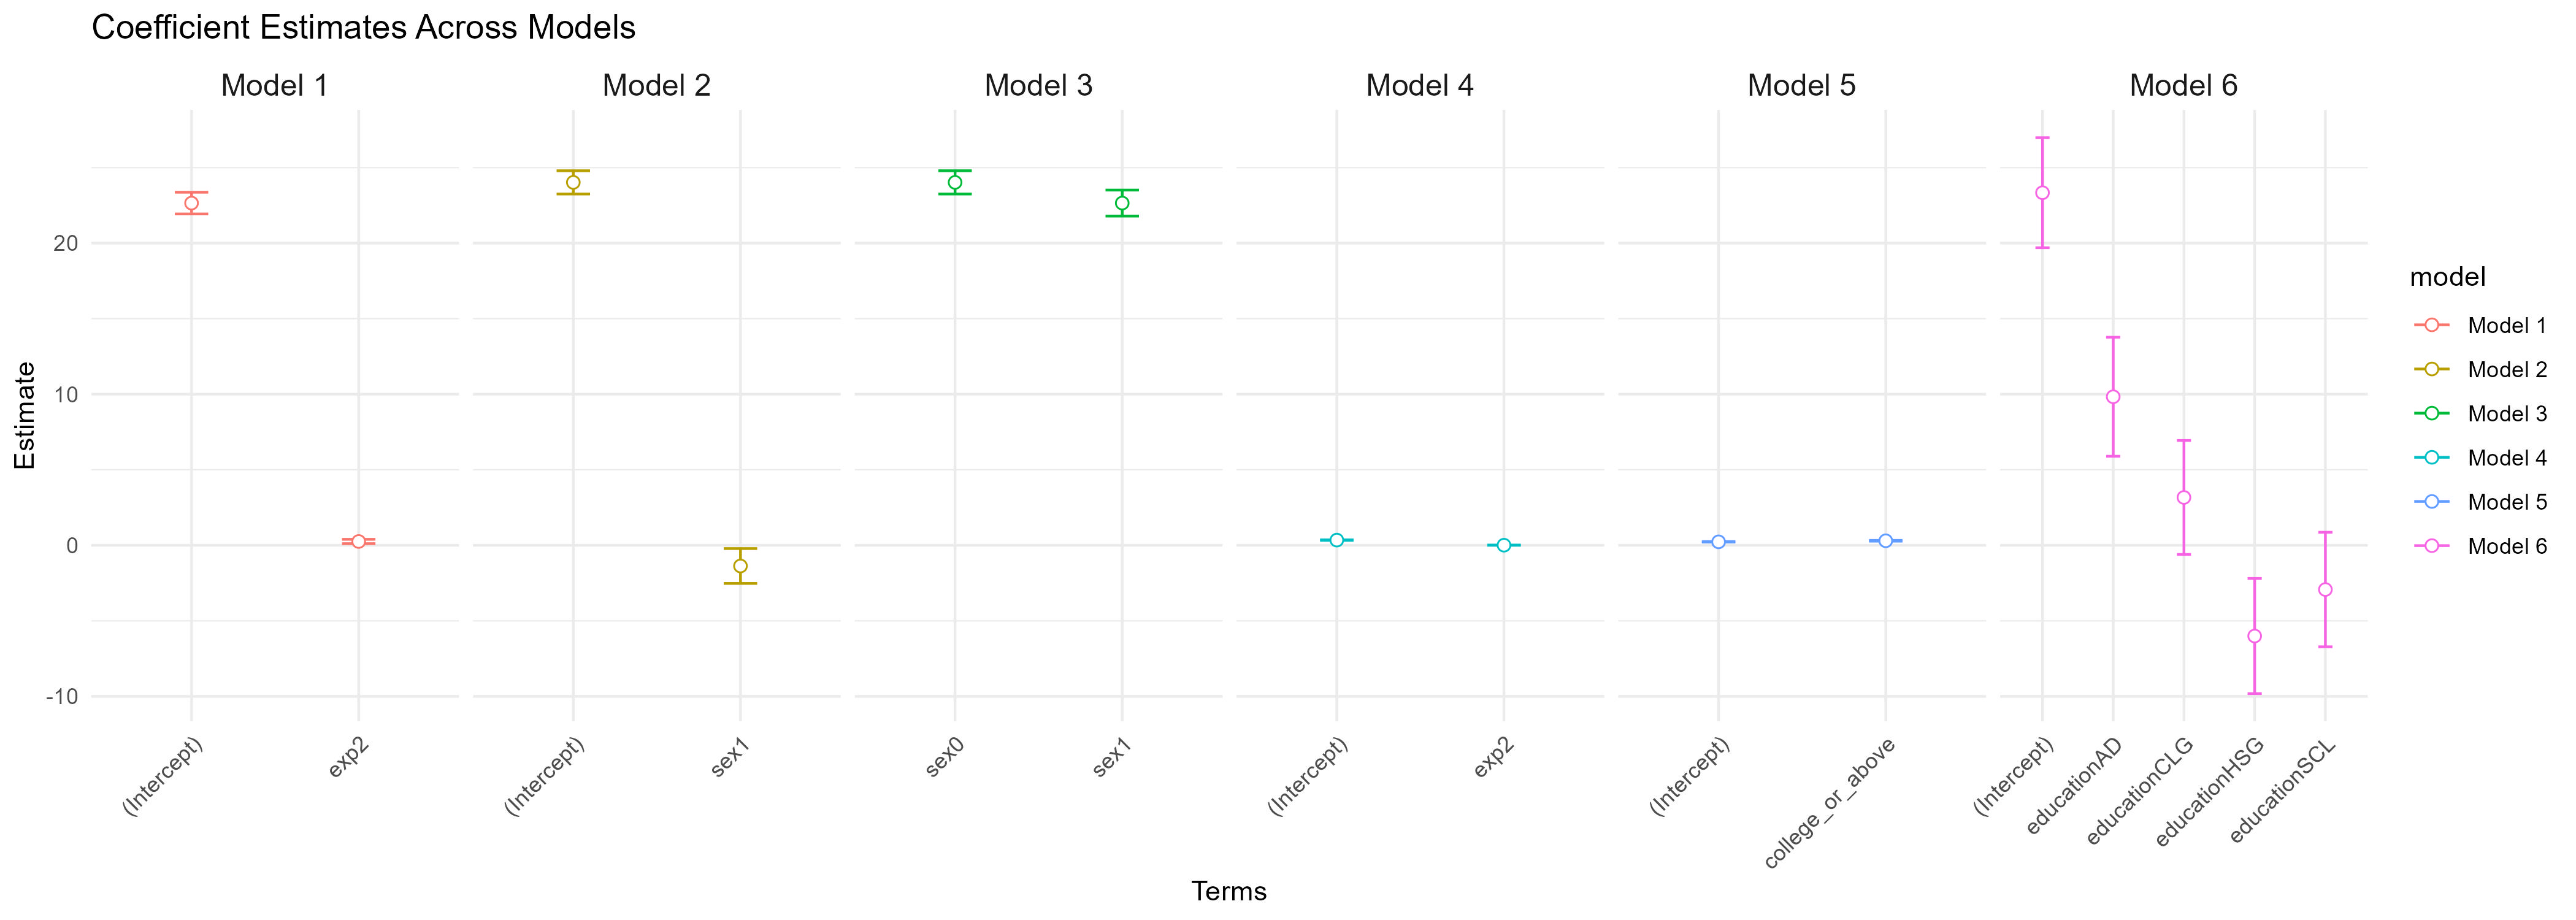

In [51]:
library(ggplot2)

temp_file2 <- tempfile(fileext = ".jpeg")

# Construct the plot
p <- ggplot(all_models_tidy, aes(x = term, y = estimate, color = model)) +
    geom_errorbar(aes(ymin = conf.low, ymax = conf.high), width = 0.2) +
    geom_point(size = 2, shape = 21, fill = "white") +
    facet_wrap(~model, scales = "free_x", nrow = 1) +
    theme_minimal() +
    labs(title = "Coefficient Estimates Across Models",
         x = "Terms",
         y = "Estimate") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          strip.background = element_blank(),
          strip.text.x = element_text(size = 12))

# Save the plot with custom dimensions
ggsave(temp_file2, plot = p, width = 14, height = 5, dpi = 300)

# Display the saved plot in the Jupyter notebook
IRdisplay::display_jpeg(file = temp_file2)
